In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import os

from pathlib import PurePath
from sklearn import metrics as skmetrics

import vxs
import vxs.utils as vxsu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
avp_set = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/')

In [22]:
def compare_fixed_personal(name):
    fixed = name + '_Fixed'
    personal = name + '_Personal'
    for x in [fixed, personal]:
        track, anno = avp_set.get(x)
        vxsu.display_track(track)

../data/avp-dataset/AVP_Dataset/Fixed/Participant_5/P5_HHclosed_Fixed.wav


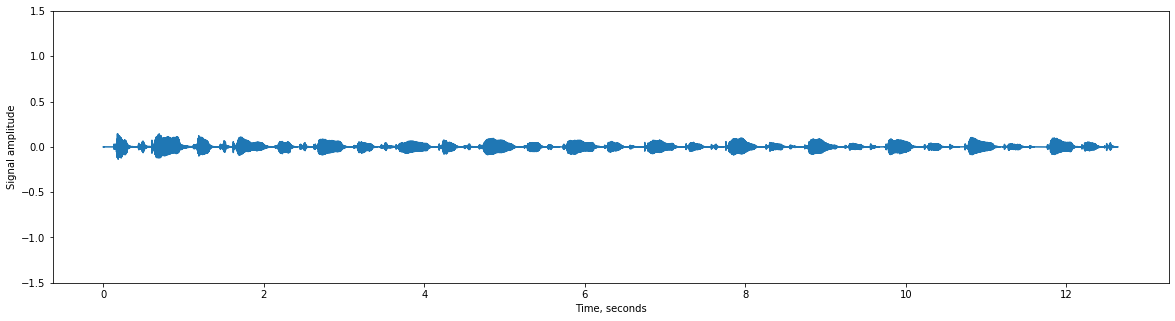

../data/avp-dataset/AVP_Dataset/Personal/Participant_5/P5_HHclosed_Personal.wav


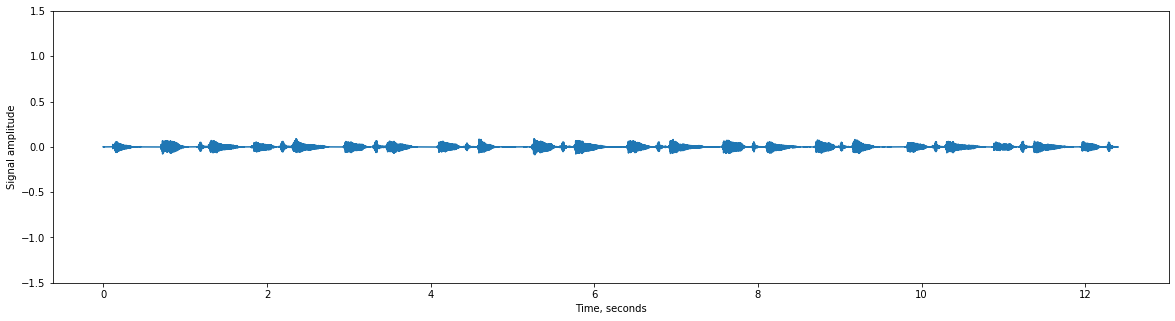

In [34]:
compare_fixed_personal('P5_HHclosed')

../data/avp-dataset/AVP_Dataset/Fixed/Participant_1/P1_Kick_Fixed.wav


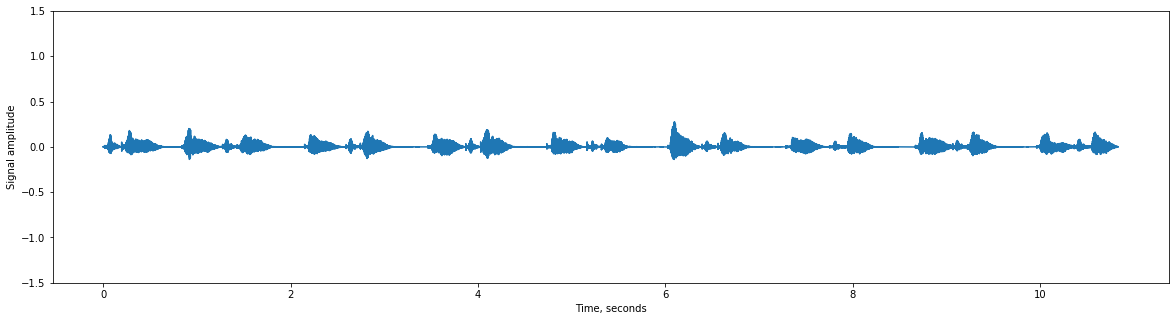

In [20]:
track, anno = avp_set_fixed.get('P1_Kick_Fixed')
vxsu.display_track(track)

### Generated stuff

In [5]:
gen_set = vxs.GenTrackSet('../data_temp/avp-gen-2/')
len(gen_set)

50

../data_temp/avp-gen-2/avp_p1_fixed_8.wav


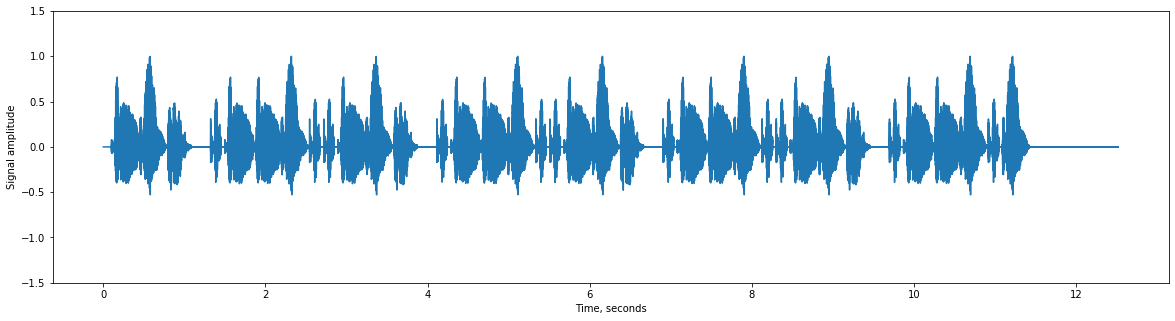

In [6]:
track, anno = gen_set.get(10)
vxsu.display_track(track)

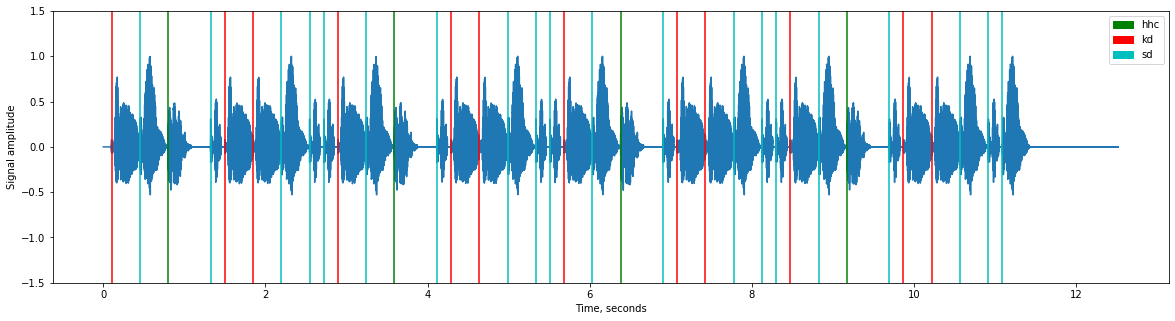

In [7]:
vxsu.plot_track(track, onsets=anno, color_events=True)

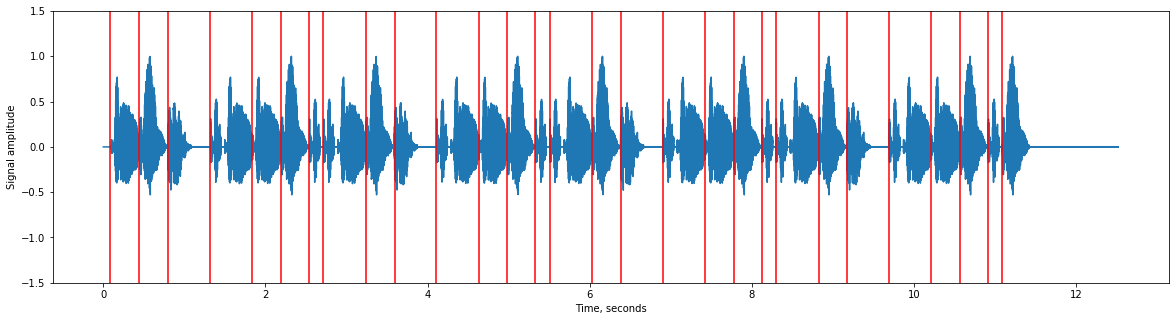

In [8]:
onsets = vxs.detect_onsets(track, method='complex')
vxsu.plot_track(track, onsets=onsets)

In [9]:
avp_segments_fixed_p10 = vxs.SegmentSet(vxs.AVPTrackSet(
    '../data/avp-dataset/AVP_Dataset/', subset='Fixed', participant=10, recordings_type='hits'))
avp_segments_fixed_p6_28 = vxs.SegmentSet(vxs.AVPTrackSet(
    '../data/avp-dataset/AVP_Dataset/', subset='Fixed', participant=np.arange(6,29), recordings_type='hits'))

In [10]:
print(len(avp_segments_fixed_p10))
print(len(avp_segments_fixed_p6_28))

125
2764


In [11]:
X, y = vxsu.unzip_dataset(avp_segments_fixed_p10)
print(len(X))
model = vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance')
model.fit(X, y)

125


Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [75]:
res_nolang = vxs.segment_classify(track, model)

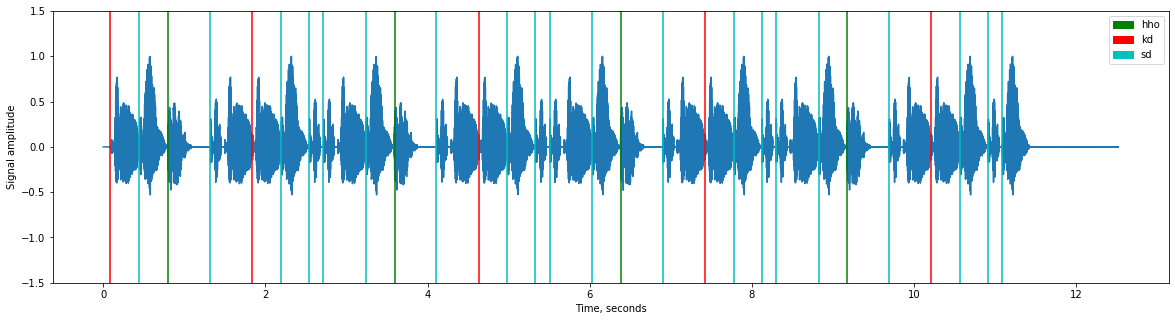

In [76]:
vxsu.plot_track(track, onsets=res_nolang['onsets'], color_events=True)

In [17]:
lang_model = vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmpq1sn6e1h/model_drum_kit.ckpt


INFO:tensorflow:Beam search yields sequence with log-likelihood: -94.880353 


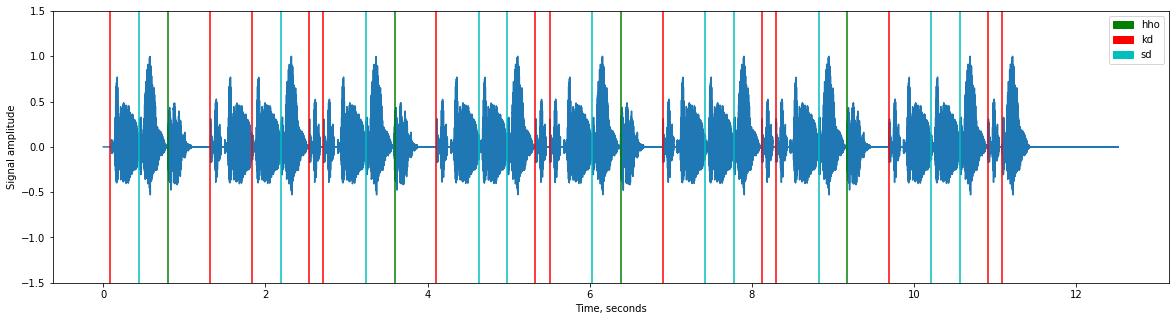

In [78]:
res_lang = vxs.segment_classify(track, model, lang_model, steps_per_iteration=4)
vxsu.plot_track(track, onsets=res_lang['onsets'], color_events=True)

In [79]:
mfcc_cf, mfcc_scores = vxs.segment_classify_all(gen_set, model, predefined_bpm=True,
                                                quantization_conflict_resolution=None)

Analysing tracks: 9it [00:04,  1.99it/s]


KeyboardInterrupt: 

In [47]:
mfcc_cf

hhc    hho     kd     sd    sil
hhc  290.0    2.0    0.0   40.0   33.0
hho   73.0  109.0    0.0    0.0    0.0
kd     0.0    0.0  677.0   16.0  314.0
sd     2.0    0.0  153.0  378.0    5.0
sil   64.0   19.0    1.0    3.0    0.0

In [48]:
mfcc_scores

prec       rec        F1
hhc  0.675991  0.794521  0.730479
hho  0.838462  0.598901  0.698718
kd   0.814681  0.672294   0.73667
sd   0.864989  0.702602  0.775385

In [49]:
mfcc_scores.mean()

prec    0.798530
rec     0.692079
F1      0.735313
dtype: float64

In [50]:
cae_wide = vxs.get_CAE_model('wide-4', '../logs/cae-initial_65536_wide-4/checkpoints/best.pth')
model_cae = vxs.make_knn_cae(cae_wide.encoder, n_neighbors=15, weights='distance')
model_cae.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(2, 2), padding=(1, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [51]:
cae_cf, cae_scores = vxs.segment_classify_all(gen_set, model_cae, predefined_bpm=True,
                                              quantization_conflict_resolution=None)

Analysing tracks: 50it [01:06,  1.32s/it]


In [52]:
cae_cf

hhc   hho     kd     sd    sil
hhc  147.0   0.0    1.0  184.0   33.0
hho  146.0  26.0    0.0   10.0    0.0
kd     0.0   0.0  676.0   17.0  314.0
sd     7.0   0.0  211.0  315.0    5.0
sil   13.0   0.0    2.0   72.0    0.0

In [53]:
cae_scores

prec       rec        F1
hhc  0.469649   0.40274  0.433628
hho         1  0.142857      0.25
kd   0.759551  0.671301  0.712704
sd   0.526756  0.585502  0.554577

In [54]:
cae_scores.mean()

prec    0.688989
rec     0.450600
F1      0.487728
dtype: float64

In [55]:
lang_cf, lang_scores = vxs.segment_classify_all(gen_set, model, lang_model, predefined_bpm=True,
                                                steps_per_iteration=4)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.388000 


Analysing tracks: 1it [00:02,  2.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.506517 


Analysing tracks: 2it [00:05,  2.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -31.526539 


Analysing tracks: 3it [00:07,  2.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.678130 


Analysing tracks: 4it [00:09,  2.49s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.229935 


Analysing tracks: 5it [00:14,  3.05s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.490526 


Analysing tracks: 6it [00:16,  2.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -78.479887 


Analysing tracks: 7it [00:20,  3.29s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -16.169953 


Analysing tracks: 8it [00:23,  3.07s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.105189 


Analysing tracks: 9it [00:25,  2.94s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -2.412373 


Analysing tracks: 10it [00:27,  2.54s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.014679 


Analysing tracks: 11it [00:29,  2.43s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -35.812810 


Analysing tracks: 12it [00:32,  2.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.490526 


Analysing tracks: 13it [00:36,  2.93s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -37.420180 


Analysing tracks: 14it [00:39,  2.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -31.483463 


Analysing tracks: 15it [00:42,  3.01s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -23.819479 


Analysing tracks: 16it [00:45,  2.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -84.210430 


Analysing tracks: 17it [00:49,  3.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -22.081959 


Analysing tracks: 18it [00:50,  2.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -88.163191 


Analysing tracks: 19it [00:55,  3.32s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.166943 


Analysing tracks: 20it [01:00,  3.85s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -8.000644 


Analysing tracks: 21it [01:04,  3.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.639690 


Analysing tracks: 22it [01:07,  3.70s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.964389 


Analysing tracks: 23it [01:12,  4.16s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -34.533799 


Analysing tracks: 24it [01:16,  3.98s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -86.102749 


Analysing tracks: 25it [01:21,  4.45s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -75.781757 


Analysing tracks: 26it [01:26,  4.41s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.224053 


Analysing tracks: 27it [01:28,  3.87s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -54.478748 


Analysing tracks: 28it [01:35,  4.79s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -140.209166 


Analysing tracks: 29it [01:43,  5.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.127365 


Analysing tracks: 30it [01:46,  4.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.235259 


Analysing tracks: 31it [01:49,  4.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -28.488299 


Analysing tracks: 32it [01:52,  4.01s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.818395 


Analysing tracks: 33it [01:55,  3.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -52.935455 


Analysing tracks: 34it [01:58,  3.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.335887 


Analysing tracks: 35it [02:01,  3.37s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -16.812290 


Analysing tracks: 36it [02:03,  3.00s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -29.020135 


Analysing tracks: 37it [02:05,  2.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -84.011514 


Analysing tracks: 38it [02:08,  2.69s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -76.146085 


Analysing tracks: 39it [02:10,  2.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -113.411153 


Analysing tracks: 40it [02:14,  2.94s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -54.638101 


Analysing tracks: 41it [02:17,  2.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.389843 


Analysing tracks: 42it [02:19,  2.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -44.338684 


Analysing tracks: 43it [02:22,  2.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.780680 


Analysing tracks: 44it [02:25,  2.71s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.962478 


Analysing tracks: 45it [02:27,  2.57s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -16.549233 


Analysing tracks: 46it [02:30,  2.68s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -82.920273 


Analysing tracks: 47it [02:33,  2.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.958008 


Analysing tracks: 48it [02:35,  2.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -54.620653 


Analysing tracks: 49it [02:38,  2.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -37.268905 


Analysing tracks: 50it [02:41,  3.24s/it]


In [56]:
lang_cf

hhc   hho     kd     sd    sil
hhc  281.0   9.0    0.0   39.0   36.0
hho  125.0  55.0    0.0    0.0    2.0
kd     0.0   0.0  679.0   13.0  315.0
sd     3.0   0.0  196.0  333.0    6.0
sil   79.0   1.0    0.0    4.0    0.0

In [57]:
lang_scores

prec       rec        F1
hhc   0.57582  0.769863  0.658851
hho  0.846154  0.302198  0.445344
kd      0.776   0.67428  0.721573
sd   0.856041  0.618959  0.718447

In [58]:
lang_scores.mean()

prec    0.763504
rec     0.591325
F1      0.636054
dtype: float64

In [59]:
lang_cae_cf, lang_cae_scores = vxs.segment_classify_all(gen_set, model_cae, lang_model, predefined_bpm=True,
                                                        steps_per_iteration=4)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.273803 


Analysing tracks: 1it [00:03,  3.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -69.382619 


Analysing tracks: 2it [00:06,  3.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -37.036726 


Analysing tracks: 3it [00:09,  3.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -39.622965 


Analysing tracks: 4it [00:12,  3.14s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -99.910919 


Analysing tracks: 5it [00:19,  4.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -39.269923 


Analysing tracks: 6it [00:22,  3.94s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -92.625451 


Analysing tracks: 7it [00:27,  4.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -16.110058 


Analysing tracks: 8it [00:30,  3.81s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.256158 


Analysing tracks: 9it [00:33,  3.50s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -2.412373 


Analysing tracks: 10it [00:35,  3.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -34.565413 


Analysing tracks: 11it [00:39,  3.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -31.341917 


Analysing tracks: 12it [00:42,  3.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.865346 


Analysing tracks: 13it [00:46,  3.52s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.885261 


Analysing tracks: 14it [00:51,  3.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -33.105262 


Analysing tracks: 15it [00:54,  3.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -23.656234 


Analysing tracks: 16it [00:59,  4.10s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -88.982190 


Analysing tracks: 17it [01:03,  4.17s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -22.081959 


Analysing tracks: 18it [01:06,  3.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -59.788646 


Analysing tracks: 19it [01:11,  4.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.048133 


Analysing tracks: 20it [01:18,  5.07s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.715709 


Analysing tracks: 21it [01:25,  5.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -70.286092 


Analysing tracks: 22it [01:30,  5.52s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.935780 


Analysing tracks: 23it [01:37,  5.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -39.709449 


Analysing tracks: 24it [01:42,  5.52s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -84.592835 


Analysing tracks: 25it [01:53,  7.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -76.036974 


Analysing tracks: 26it [01:57,  6.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -60.998305 


Analysing tracks: 27it [02:00,  5.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -53.735589 


Analysing tracks: 28it [02:07,  5.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -107.989877 


Analysing tracks: 29it [02:17,  7.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.152290 


Analysing tracks: 30it [02:21,  6.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.235259 


Analysing tracks: 31it [02:25,  5.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -31.261917 


Analysing tracks: 32it [02:29,  5.15s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -35.274325 


Analysing tracks: 33it [02:33,  4.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -45.469058 


Analysing tracks: 34it [02:36,  4.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -49.259875 


Analysing tracks: 35it [02:41,  4.32s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.234677 


Analysing tracks: 36it [02:45,  4.29s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -28.582176 


Analysing tracks: 37it [02:47,  3.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.877046 


Analysing tracks: 38it [02:56,  5.21s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.005762 


Analysing tracks: 39it [02:59,  4.63s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -117.975539 


Analysing tracks: 40it [03:05,  4.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.163548 


Analysing tracks: 41it [03:09,  4.54s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.601019 


Analysing tracks: 42it [03:12,  4.18s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -47.645043 


Analysing tracks: 43it [03:16,  4.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.322038 


Analysing tracks: 44it [03:20,  3.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -63.262734 


Analysing tracks: 45it [03:24,  3.96s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -15.300463 


Analysing tracks: 46it [03:27,  3.84s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -59.668527 


Analysing tracks: 47it [03:32,  4.07s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -23.968134 


Analysing tracks: 48it [03:35,  3.90s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -45.372128 


Analysing tracks: 49it [03:40,  4.12s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -37.767194 


Analysing tracks: 50it [03:44,  4.49s/it]


In [60]:
lang_cae_cf

hhc   hho     kd     sd    sil
hhc  137.0   0.0    0.0  192.0   36.0
hho  101.0  27.0    0.0   52.0    2.0
kd     0.0   0.0  673.0   19.0  315.0
sd     4.0   0.0  200.0  328.0    6.0
sil   20.0   0.0    3.0   61.0    0.0

In [61]:
lang_cae_scores

prec       rec        F1
hhc  0.522901  0.375342  0.437002
hho         1  0.148352  0.258373
kd   0.768265  0.668322  0.714817
sd   0.503067  0.609665  0.551261

In [62]:
lang_cae_scores.mean()

prec    0.698558
rec     0.450420
F1      0.490363
dtype: float64

In [88]:
lang_cf2, lang_scores2 = vxs.segment_classify_all(gen_set, model, lang_model, predefined_bpm=True,
                                                  steps_per_iteration=4, beam_size=10, silence_prob=0.01)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -65.500341 


Analysing tracks: 1it [00:20, 20.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.953074 


Analysing tracks: 2it [00:31, 17.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -21.245562 


Analysing tracks: 3it [00:52, 18.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.027652 


Analysing tracks: 4it [00:58, 14.92s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -87.879636 


Analysing tracks: 5it [01:06, 13.00s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -12.274304 


Analysing tracks: 6it [01:09, 10.05s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -26.290272 


Analysing tracks: 7it [01:15,  8.64s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -50.331495 


Analysing tracks: 8it [01:18,  6.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -47.203371 


Analysing tracks: 9it [01:22,  6.18s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -32.009699 


Analysing tracks: 10it [01:25,  5.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -90.419319 


Analysing tracks: 11it [01:38,  7.52s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -130.403923 


Analysing tracks: 12it [01:45,  7.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -41.725054 


Analysing tracks: 13it [01:48,  5.98s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -109.962678 


Analysing tracks: 14it [01:55,  6.49s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -21.294443 


Analysing tracks: 15it [01:58,  5.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -9.438965 


Analysing tracks: 16it [02:09,  7.09s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -25.102832 


Analysing tracks: 17it [02:11,  5.50s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.744001 


Analysing tracks: 18it [02:14,  4.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -82.177550 


Analysing tracks: 19it [02:20,  5.12s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -23.251446 


Analysing tracks: 20it [02:25,  5.19s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.162830 


Analysing tracks: 21it [02:29,  4.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.520019 


Analysing tracks: 22it [02:32,  4.21s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.684466 


Analysing tracks: 23it [02:47,  7.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -41.816743 


Analysing tracks: 24it [02:55,  7.60s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -8.189173 


Analysing tracks: 25it [03:02,  7.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -45.643521 


Analysing tracks: 26it [03:07,  6.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -29.191248 


Analysing tracks: 27it [03:14,  6.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.104291 


Analysing tracks: 28it [03:18,  5.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -27.437154 


Analysing tracks: 29it [03:25,  6.27s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -50.032383 


Analysing tracks: 30it [03:37,  8.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -101.687456 


Analysing tracks: 31it [03:42,  7.18s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -35.244225 


Analysing tracks: 32it [03:50,  7.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -28.291768 


Analysing tracks: 33it [04:09, 10.85s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.839295 


Analysing tracks: 34it [04:13,  8.81s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.341621 


Analysing tracks: 35it [04:20,  8.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.198438 


Analysing tracks: 36it [04:24,  6.86s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.504495 


Analysing tracks: 37it [04:29,  6.35s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.566289 


Analysing tracks: 38it [04:33,  5.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -115.524365 


Analysing tracks: 39it [04:45,  7.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.522891 


Analysing tracks: 40it [04:48,  6.31s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.427200 


Analysing tracks: 41it [04:53,  5.77s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -48.995818 


Analysing tracks: 42it [04:59,  5.90s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -81.148474 


Analysing tracks: 43it [05:02,  5.17s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -121.711246 


Analysing tracks: 44it [05:08,  5.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.769332 


Analysing tracks: 45it [05:13,  5.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.134351 


Analysing tracks: 46it [05:21,  5.94s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -47.088736 


Analysing tracks: 47it [05:25,  5.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.902786 


Analysing tracks: 48it [05:29,  4.96s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -43.179117 


Analysing tracks: 49it [05:46,  8.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.993687 


Analysing tracks: 50it [06:03,  7.28s/it]


In [89]:
lang_cf2

hhc    hho     kd     sd    sil
hhc  767.0    2.0    0.0  174.0  110.0
hho  222.0  105.0    0.0    0.0    8.0
kd     1.0    0.0  419.0    9.0  325.0
sd    17.0    0.0   64.0  303.0    3.0
sil  148.0    0.0    1.0    8.0    0.0

In [90]:
lang_scores2

prec       rec        F1
hhc  0.664069  0.728395  0.694746
hho  0.981308  0.313433  0.475113
kd   0.865702  0.555703  0.676898
sd    0.61336  0.782946  0.687855

In [91]:
lang_scores2.mean()

prec    0.781110
rec     0.595119
F1      0.633653
dtype: float64

### Sanity check: using ground-truth onsets

In [12]:
trueonsets_mfcc_cf, trueonsets_mfcc_scores = vxs.segment_classify_all(
    gen_set, model, predefined_bpm=True, predefined_onsets=True)

Analysing tracks: 50it [00:26,  1.88it/s]


In [13]:
trueonsets_mfcc_cf

hhc    hho      kd     sd  sil
hhc  150.0  214.0     1.0    0.0  0.0
hho    1.0  181.0     0.0    0.0  0.0
kd     0.0    0.0  1007.0    0.0  0.0
sd     0.0   40.0    87.0  411.0  0.0
sil    0.0    0.0     0.0    0.0  0.0

In [14]:
trueonsets_mfcc_scores

prec       rec        F1
hhc  0.993377  0.410959  0.581395
hho  0.416092  0.994505   0.58671
kd   0.919635         1  0.958135
sd          1  0.763941  0.866175

In [15]:
trueonsets_mfcc_scores.mean()

prec    0.832276
rec     0.792351
F1      0.748104
dtype: float64

In [18]:
trueonsets_lang_cf, trueonsets_lang_scores = vxs.segment_classify_all(
    gen_set, model, lang_model, predefined_bpm=True, predefined_onsets=True, steps_per_iteration=4)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -29.016772 


Analysing tracks: 1it [00:04,  4.13s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -67.293510 


Analysing tracks: 2it [00:06,  3.53s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -21.290447 


Analysing tracks: 3it [00:08,  3.07s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.396744 


Analysing tracks: 4it [00:10,  2.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -120.505777 


Analysing tracks: 5it [00:25,  6.34s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -19.806600 


Analysing tracks: 6it [00:28,  5.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.807560 


Analysing tracks: 7it [00:36,  6.37s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -8.220994 


Analysing tracks: 8it [00:39,  5.13s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -25.466328 


Analysing tracks: 9it [00:41,  4.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -5.663862 


Analysing tracks: 10it [00:43,  3.55s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -39.402329 


Analysing tracks: 11it [00:46,  3.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.452891 


Analysing tracks: 12it [00:49,  3.17s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.194606 


Analysing tracks: 13it [00:52,  3.09s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -52.151216 


Analysing tracks: 14it [00:57,  3.69s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -17.315076 


Analysing tracks: 15it [01:00,  3.54s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -29.757291 


Analysing tracks: 16it [01:04,  3.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.286734 


Analysing tracks: 17it [01:08,  3.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -11.934712 


Analysing tracks: 18it [01:10,  3.16s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -34.645972 


Analysing tracks: 19it [01:13,  3.19s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -47.194964 


Analysing tracks: 20it [01:18,  3.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -32.390324 


Analysing tracks: 21it [01:25,  4.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.149890 


Analysing tracks: 22it [01:30,  4.77s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -70.378619 


Analysing tracks: 23it [01:35,  4.98s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -21.030694 


Analysing tracks: 24it [01:38,  4.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -76.569366 


Analysing tracks: 25it [01:45,  5.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.975800 


Analysing tracks: 26it [01:51,  5.19s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -59.931994 


Analysing tracks: 27it [01:54,  4.54s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.141969 


Analysing tracks: 28it [02:08,  7.43s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -108.851165 


Analysing tracks: 29it [02:28, 11.33s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -83.617320 


Analysing tracks: 30it [02:31,  8.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -18.890406 


Analysing tracks: 31it [02:36,  7.50s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.417910 


Analysing tracks: 32it [02:43,  7.41s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -27.338146 


Analysing tracks: 33it [02:47,  6.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -27.330188 


Analysing tracks: 34it [02:50,  5.53s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -49.614332 


Analysing tracks: 35it [02:53,  4.79s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -19.418469 


Analysing tracks: 36it [02:56,  4.03s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -9.002367 


Analysing tracks: 37it [02:58,  3.55s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -52.183315 


Analysing tracks: 38it [03:03,  3.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -74.290330 


Analysing tracks: 39it [03:06,  3.58s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -133.356083 


Analysing tracks: 40it [03:12,  4.36s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -63.837939 


Analysing tracks: 41it [03:15,  3.87s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -30.073301 


Analysing tracks: 42it [03:17,  3.50s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -31.202067 


Analysing tracks: 43it [03:22,  4.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -25.527016 


Analysing tracks: 44it [03:25,  3.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.058565 


Analysing tracks: 45it [03:27,  3.16s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -20.188876 


Analysing tracks: 46it [03:32,  3.65s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -53.873777 


Analysing tracks: 47it [03:36,  3.76s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -19.755853 


Analysing tracks: 48it [03:38,  3.35s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -50.282749 


Analysing tracks: 49it [03:42,  3.63s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -35.062815 


Analysing tracks: 50it [03:46,  4.52s/it]


In [19]:
trueonsets_lang_cf

hhc    hho     kd     sd  sil
hhc  205.0  156.0    4.0    0.0  0.0
hho   15.0  167.0    0.0    0.0  0.0
kd     1.0    0.0  995.0   11.0  0.0
sd    38.0   17.0  136.0  347.0  0.0
sil    0.0    0.0    0.0    0.0  0.0

In [20]:
trueonsets_lang_scores

prec       rec        F1
hhc  0.791506  0.561644  0.657051
hho  0.491176  0.917582  0.639847
kd   0.876652  0.988083  0.929038
sd   0.969274  0.644981  0.774554

In [21]:
trueonsets_lang_scores.mean()

prec    0.782152
rec     0.778073
F1      0.750122
dtype: float64

In [27]:
cwide_cf, cwide_scores = vxs.segment_classify_all(gen_set, model_cae, predefined_bpm=True,
                                                  quantization_conflict_resolution=None)

Analysing tracks: 50it [01:16,  1.53s/it]


In [28]:
cwide_cf

hhc   hho     kd     sd    sil
hhc  367.0   0.0  113.0  472.0  101.0
hho  146.0  85.0    0.0  104.0    0.0
kd     0.0   0.0  421.0   22.0  311.0
sd    50.0   0.0  237.0   99.0    1.0
sil    8.0   0.0    8.0  151.0    0.0

In [40]:
cwide_cf.loc['hho', 'hhc']

146.0

In [29]:
cwide_scores

prec       rec        F1
hhc  0.348528  0.642732   0.45197
hho  0.253731         1  0.404762
kd   0.558355  0.540436   0.54925
sd   0.255814  0.116745  0.160324

In [30]:
cwide_scores.mean()

prec    0.354107
rec     0.574978
F1      0.391577
dtype: float64

In [31]:
lang_cw_cf, lang_cw_scores = vxs.segment_classify_all(gen_set, model_cae, lang_model, predefined_bpm=True,
                                                      steps_per_iteration=4, beam_size=5)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.467619 


Analysing tracks: 1it [00:30, 30.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -92.954670 


Analysing tracks: 2it [00:36, 22.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -55.412680 


Analysing tracks: 3it [00:48, 19.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.034865 


Analysing tracks: 4it [00:52, 14.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -110.428432 


Analysing tracks: 5it [00:56, 11.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.534127 


Analysing tracks: 6it [00:59,  9.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -69.598919 


Analysing tracks: 7it [01:02,  7.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -48.961862 


Analysing tracks: 8it [01:06,  6.34s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.315867 


Analysing tracks: 9it [01:09,  5.36s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -34.227495 


Analysing tracks: 10it [01:11,  4.31s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -139.103029 


Analysing tracks: 11it [01:20,  5.70s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -129.145971 


Analysing tracks: 12it [01:25,  5.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.952572 


Analysing tracks: 13it [01:27,  4.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -96.760351 


Analysing tracks: 14it [01:31,  4.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -49.759155 


Analysing tracks: 15it [01:33,  3.64s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -78.774110 


Analysing tracks: 16it [01:53,  8.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.128610 


Analysing tracks: 17it [01:55,  6.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.078921 


Analysing tracks: 18it [01:57,  5.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -99.996665 


Analysing tracks: 19it [02:02,  5.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.340344 


Analysing tracks: 20it [02:06,  4.81s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.015766 


Analysing tracks: 21it [02:09,  4.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.342292 


Analysing tracks: 22it [02:11,  3.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.836558 


Analysing tracks: 23it [02:19,  4.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.787585 


Analysing tracks: 24it [02:24,  4.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -53.077088 


Analysing tracks: 25it [02:35,  6.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.115231 


Analysing tracks: 26it [02:38,  5.68s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.096362 


Analysing tracks: 27it [02:43,  5.29s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.972465 


Analysing tracks: 28it [02:45,  4.48s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.203970 


Analysing tracks: 29it [02:52,  5.04s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.563095 


Analysing tracks: 30it [02:59,  5.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -97.022107 


Analysing tracks: 31it [03:02,  4.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.924187 


Analysing tracks: 32it [03:06,  4.48s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -54.180359 


Analysing tracks: 33it [03:16,  6.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.515571 


Analysing tracks: 34it [03:18,  5.06s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -67.882079 


Analysing tracks: 35it [03:23,  4.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -26.888749 


Analysing tracks: 36it [03:25,  4.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.564333 


Analysing tracks: 37it [03:29,  4.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -80.499788 


Analysing tracks: 38it [03:32,  3.73s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.854177 


Analysing tracks: 39it [03:48,  7.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.363079 


Analysing tracks: 40it [03:50,  5.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.055798 


Analysing tracks: 41it [03:54,  5.10s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.473395 


Analysing tracks: 42it [03:57,  4.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -98.406987 


Analysing tracks: 43it [03:59,  3.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -101.510722 


Analysing tracks: 44it [04:04,  4.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.525251 


Analysing tracks: 45it [04:07,  3.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.054468 


Analysing tracks: 46it [04:12,  4.22s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.922741 


Analysing tracks: 47it [04:15,  3.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.715265 


Analysing tracks: 48it [04:17,  3.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -44.473912 


Analysing tracks: 49it [04:28,  5.59s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.881484 


Analysing tracks: 50it [04:38,  5.57s/it]


In [32]:
lang_cw_cf

hhc   hho     kd     sd    sil
hhc  420.0   0.0   85.0  442.0  106.0
hho  142.0  27.0   18.0  145.0    3.0
kd     2.0   0.0  355.0   83.0  314.0
sd    82.0   0.0  150.0  153.0    2.0
sil    4.0   0.0    8.0  148.0    0.0

In [33]:
lang_cw_scores

prec       rec        F1
hhc   0.39886  0.646154  0.493247
hho  0.080597         1  0.149171
kd   0.470822  0.576299  0.518248
sd   0.395349   0.15757  0.225331

In [34]:
lang_cw_scores.mean()

prec    0.336407
rec     0.595006
F1      0.346500
dtype: float64

#### Cutting AVP dataset into chunks

In [ ]:
savedir_f = '../data_temp/avp-cut/fixed/participant_{}/'

for p in participants:
    participant_segments[p] = {}
    ds = vxs.SegmentSet(vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed',
                                        participant=p, recordings_type='hits'), frame_window=None)
    pdir = savedir_f.format(p)
    os.makedirs(pdir, exist_ok=True)
    cls_counters = {}
    for i in range(len(ds)):
        segm, cl = ds[i]
        try:
            cl_i = cls_counters[cl]
        except KeyError:
            cls_counters[cl] = 0
            cl_i = 0
        segm.save((pdir + f'{cl}_{cl_i}.wav'))
        cls_counters[cl] += 1